In [94]:
import numpy as np
import pandas as pd
import lifetimes
import datetime

## Initial EDA

In [50]:
df = pd.read_csv('../trash/online_retail.csv')

In [51]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [62]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,354321.000000,354321.000000,354321.000000
mean,8.348212,2.651029,15552.486392
std,9.245021,2.248187,1594.527150
min,1.000000,0.420000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,36.000000,8.500000,18287.000000


In [53]:
# Some clean up is required before proceeding.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    495478 non-null  object 
 1   StockCode    495478 non-null  object 
 2   Description  494024 non-null  object 
 3   Quantity     495478 non-null  int64  
 4   InvoiceDate  495478 non-null  object 
 5   UnitPrice    495478 non-null  float64
 6   CustomerID   361878 non-null  float64
 7   Country      495478 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 30.2+ MB


<AxesSubplot:>

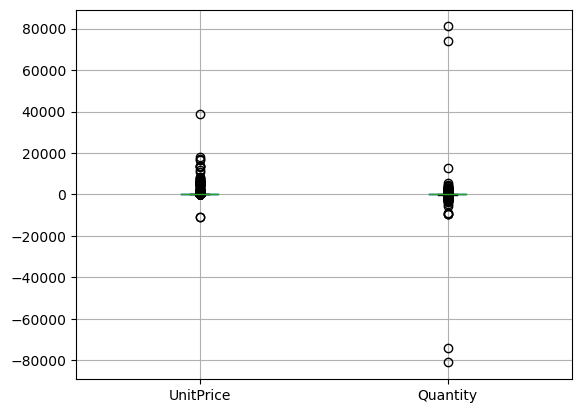

In [54]:
# There are some outliers that should be removed before continuing.
df[['UnitPrice', 'Quantity']].boxplot()

### Clean up

In [55]:
df = df[df['Quantity'] > 0 ] # exclude the orders with 0 value
df = df[df['UnitPrice'] > 0] # exclude the Unit Price with 0 value
df = df[~df['InvoiceNo'].str.contains("C",na=False)]  # C indicates the returned orders we don't want them as well
df.dropna(inplace=True)  # inplace=True means we dropped them permanently

### Outliers 

In [56]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):
    # the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary, lower_boundary = find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary, 
                   np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [57]:
# Removing Outliers
capping_outliers(df, 'UnitPrice')
capping_outliers(df, 'Quantity')

<AxesSubplot:>

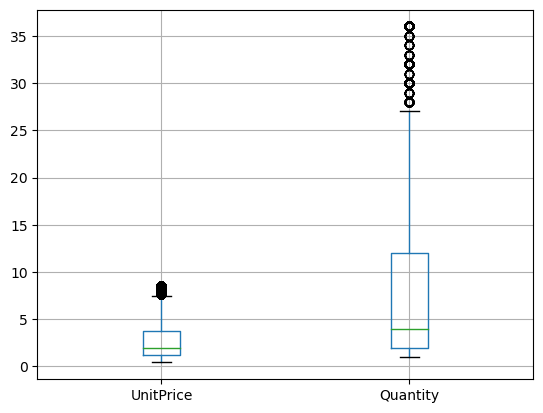

In [58]:
df[['UnitPrice', 'Quantity']].boxplot()

In [66]:
# Adding Total Price Column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

## Lifetime Value Analysis

When it comes to LTV analysis using the RFM method, we need the following information: Recency, Frequency, T, Monetary data. Here we are using the `summary_data_from_transaction_data` method from the lifetimes module:
- **Frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
- **Recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
- **T** represents the age of the customer at whatever time units are chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- **Monetary Value** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

In [70]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','TotalPrice',
                                                         observation_period_end='2011-12-09')

In [73]:
clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12747.0,10.0,367.0,369.0,375.725000
12748.0,112.0,373.0,373.0,257.314911
12749.0,3.0,210.0,213.0,999.106667
12820.0,3.0,323.0,326.0,256.573333


In [96]:
datetime.date(2011, 12, 9) - datetime.date(2011, 5, 10)

datetime.timedelta(days=213)

In [112]:
df[(df['CustomerID'] == 12749)]['TotalPrice'].sum()/4

952.9050000000001